In [110]:
import pymc3 as pm
import theano.tensor as tt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

%matplotlib inline

In [128]:
df = pd.read_csv('data/test.csv', index_col = 0)
df.index = df.index.rename('subject')
df = df.reset_index()

df['subject'] = df.subject.astype('category').cat.codes
df.head()

,subject,t,Cl,ka,ke,x_0,x_1,x_2,x_3,x_4,y,y_obs
0,0,0.500000,1.133724,0.423938,0.430075,1.0,0.972925,-2.049654,0.0,0.0,0.324755,0.401320
1,0,2.142857,1.133724,0.423938,0.430075,1.0,0.972925,-2.049654,0.0,0.0,0.690113,0.724060
2,0,3.785714,1.133724,0.423938,0.430075,1.0,0.972925,-2.049654,0.0,0.0,0.604532,0.679871
3,0,5.428571,1.133724,0.423938,0.430075,1.0,0.972925,-2.049654,0.0,0.0,0.429838,0.562458
4,0,7.071429,1.133724,0.423938,0.430075,1.0,0.972925,-2.049654,0.0,0.0,0.277638,0.347382


In [129]:
idx = df.subject.values
t = df.t.values
yobs = df.y_obs.values
X = df.drop_duplicates('subject').loc[:, df.columns[df.columns.str.contains('x')]].iloc[:, 1:].values

n,p = X.shape

In [120]:
with pm.Model() as pkmodel:
     
    baseline_cl = pm.Bound(pm.Normal, lower=0)('baseline_cl', mu = tt.log(20), sd=1)
    baseline_ka = pm.Normal('baseline_ka', mu = 0, sd=1)
    baseline_ke = pm.Bound(pm.Normal, upper=baseline_ka)('baseline_ke', mu = 0, sd=1)
    
    beta_cl = pm.Normal('beta_cl', mu = 0, sd = 0.1, shape = p)
    beta_ka = pm.Normal('beta_ka', mu = 0, sd = 0.1, shape = p)
    beta_ke = pm.Normal('beta_ke', mu = 0, sd = 0.1, shape = p)
    
    sigma = pm.HalfCauchy('sigma',1)
    sigma_cl = pm.HalfCauchy('sigma_cl',1)
    sigma_ka = pm.HalfCauchy('sigma_ka',1)
    sigma_ke = pm.HalfCauchy('sigma_ke', 1)
    
    z_cl = pm.Normal('z_cl', mu = 0, sd = 1, shape = n)
    z_ka = pm.Normal('z_ka', mu = 0, sd = 1, shape = n)
    z_ke = pm.Normal('z_ke', mu = 0, sd = 1, shape = n)
    
    cl = pm.Deterministic('Cl', tt.exp(baseline_cl + tt.dot(X,beta_cl) + z_cl*sigma_cl))
    ka = pm.Deterministic('ka', tt.exp(baseline_ka + tt.dot(X,beta_ka) + z_ka*sigma_ka))
    ke = pm.Deterministic('ke', tt.exp(baseline_ke + tt.dot(X,beta_ke) + z_ke*sigma_ke))
    
    CL = cl[idx]
    KA = ka[idx]
    KE = ke[idx]
    
    c = (5/CL)*(KE*KA)/(KE-KA)*(tt.exp(-KA*t) - tt.exp(-KE*t))
    concentration = pm.Deterministic('conc', c)
    
    Y = pm.Lognormal('Yobs', mu = tt.log(concentration), sd = sigma, observed = yobs)
    
    prior = pm.sample_prior_predictive(samples=1)
    trace = pm.sample(2000, chains = 4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [z_ke, z_ka, z_cl, sigma_ke, sigma_ka, sigma_cl, sigma, beta_ke, beta_ka, beta_cl, baseline_ke, baseline_ka, baseline_cl]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [01:57<00:00, 85.10draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [134]:
d = az.from_pymc3(trace)

?az.plot_parallel

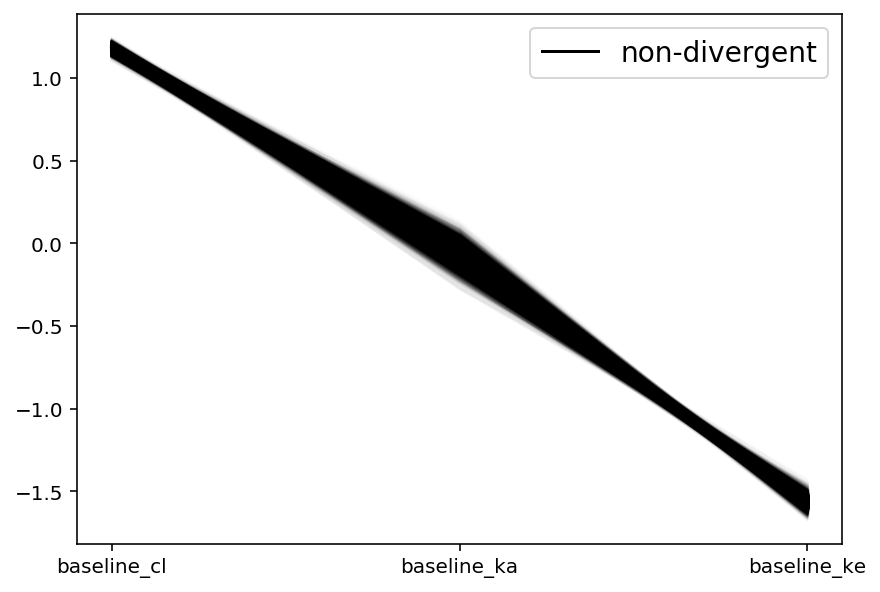

In [122]:
az.plot_parallel(data = d, 
                 var_names=['baseline_cl','baseline_ka','baseline_ke'])

In [130]:
df['pred'] = trace['conc'].mean(axis=0)

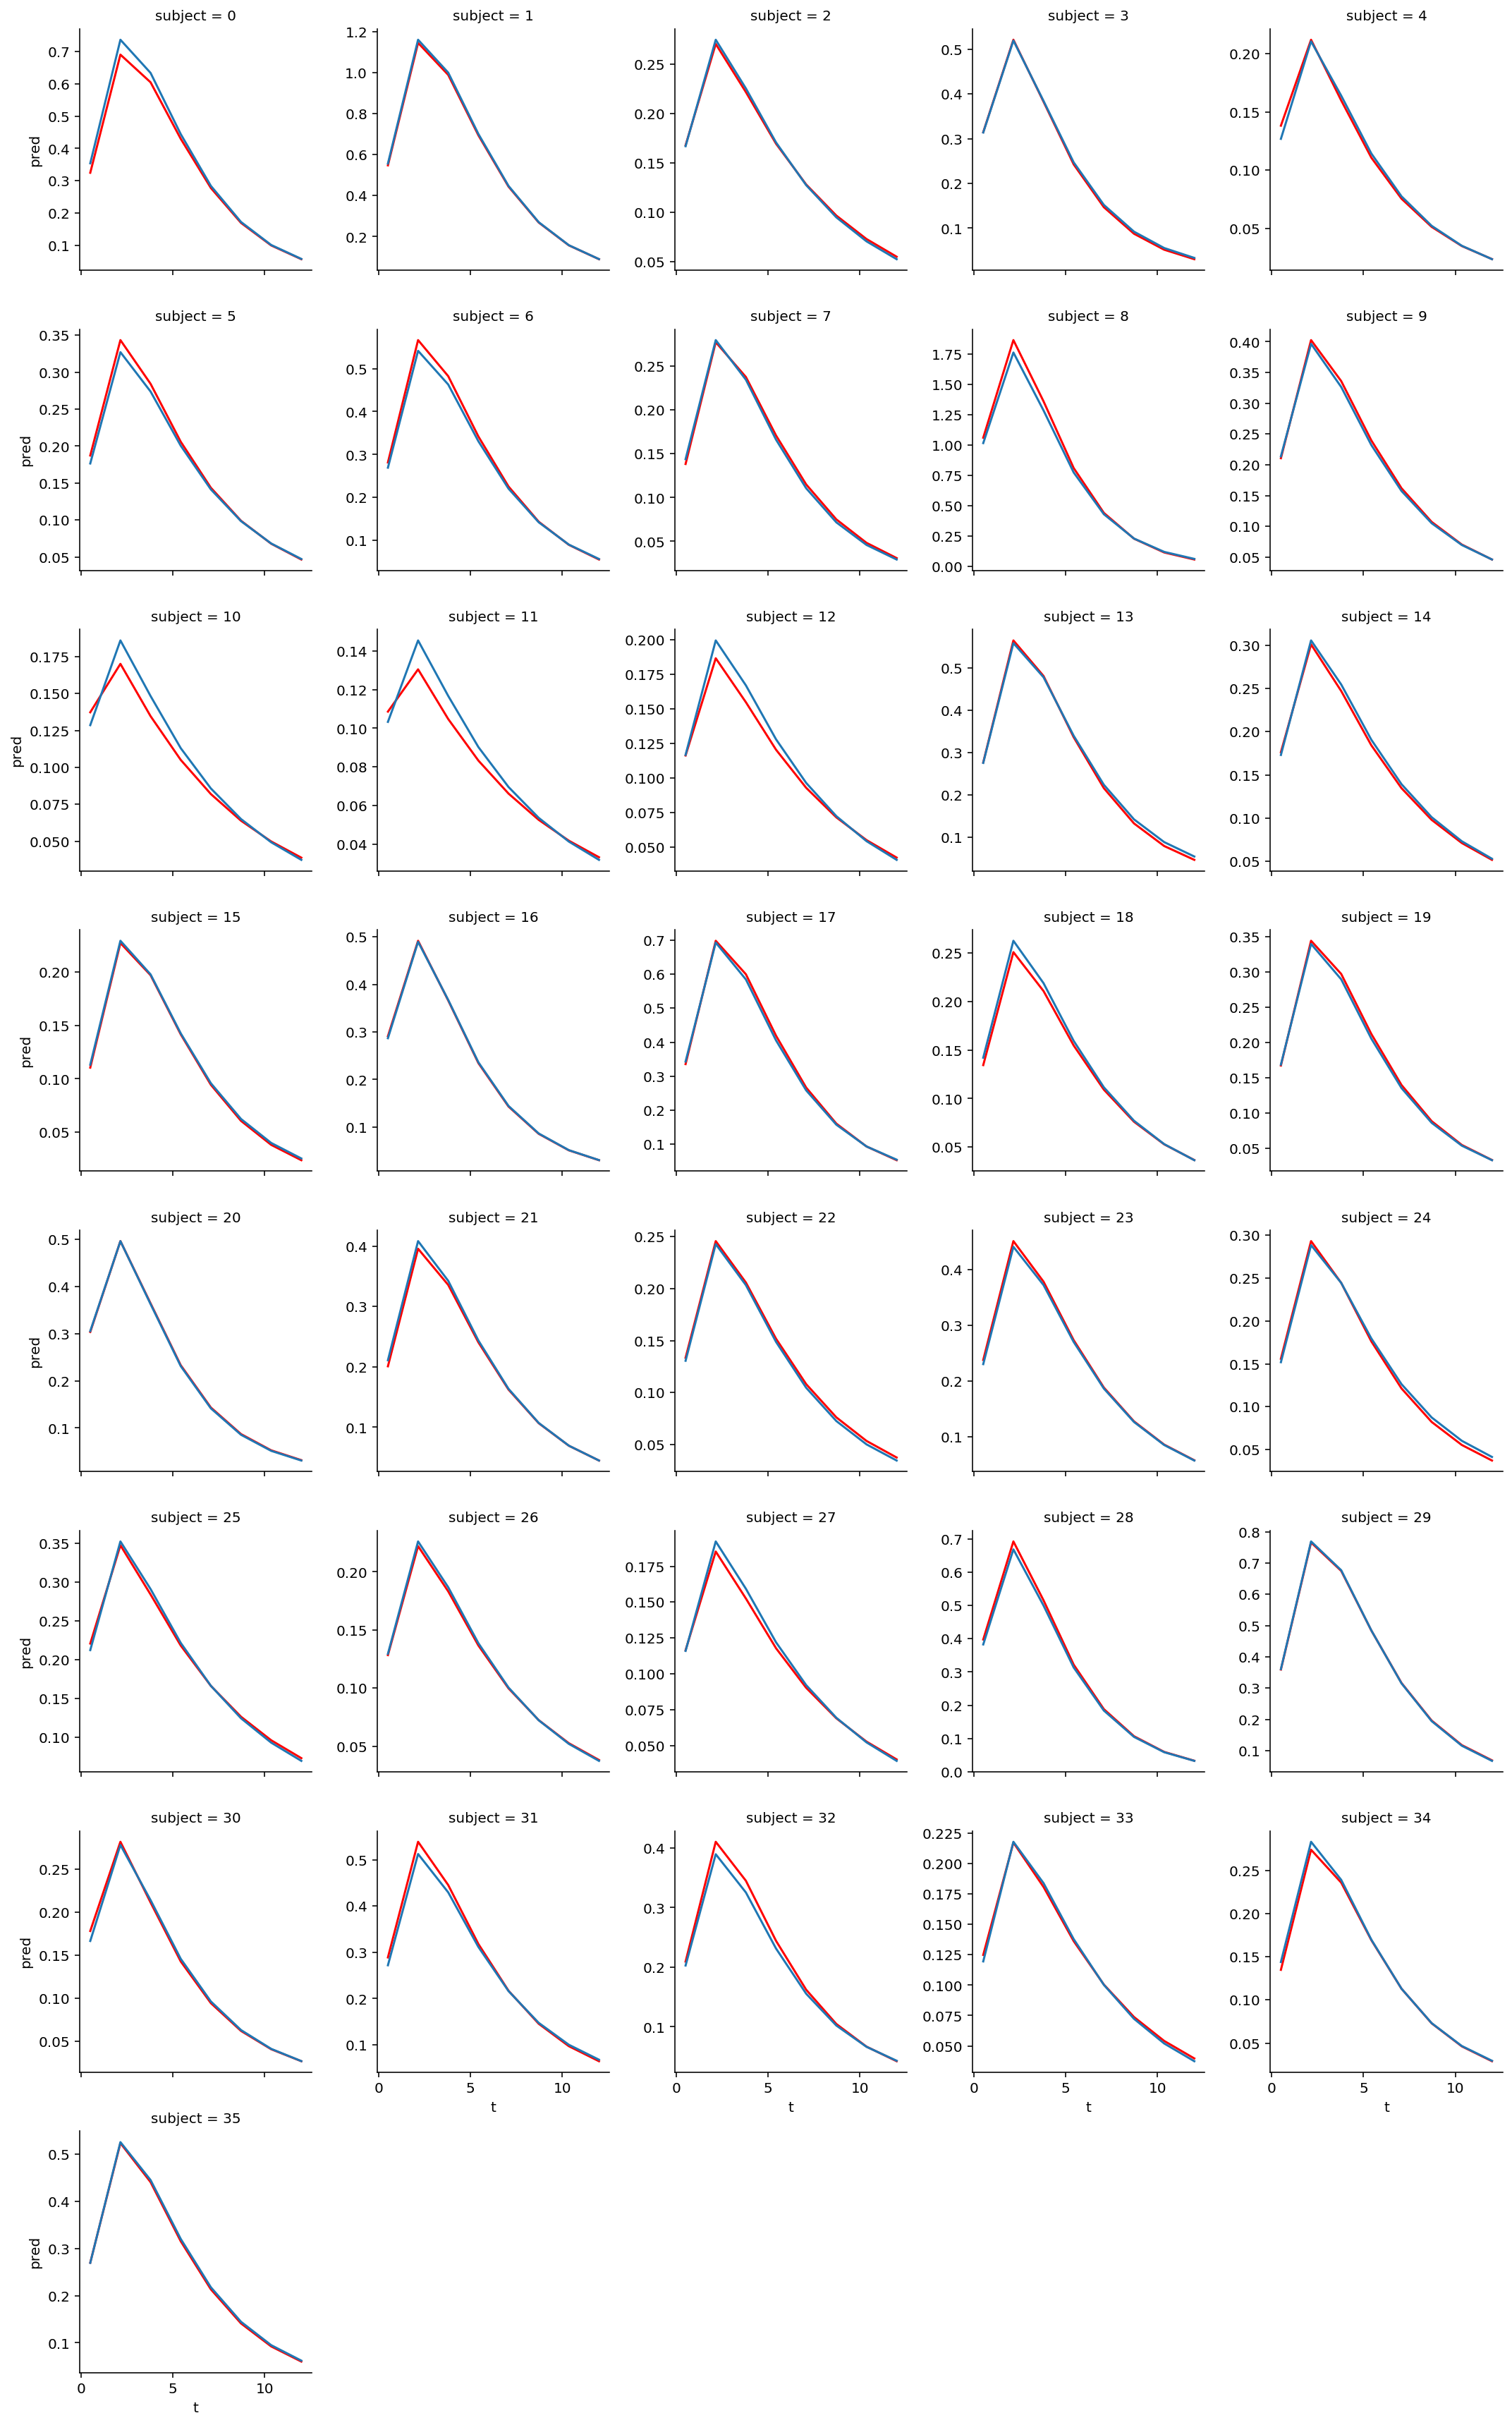

In [133]:
g = sns.FacetGrid(data = df, col='subject', col_wrap=5, sharey=False)

g.map_dataframe(sns.lineplot,'t', 'y', color='red')
g.map_dataframe(sns.lineplot,'t', 'pred', color='C0')

(<Figure size 432x518.4 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c590ebeb8>],
       dtype=object))

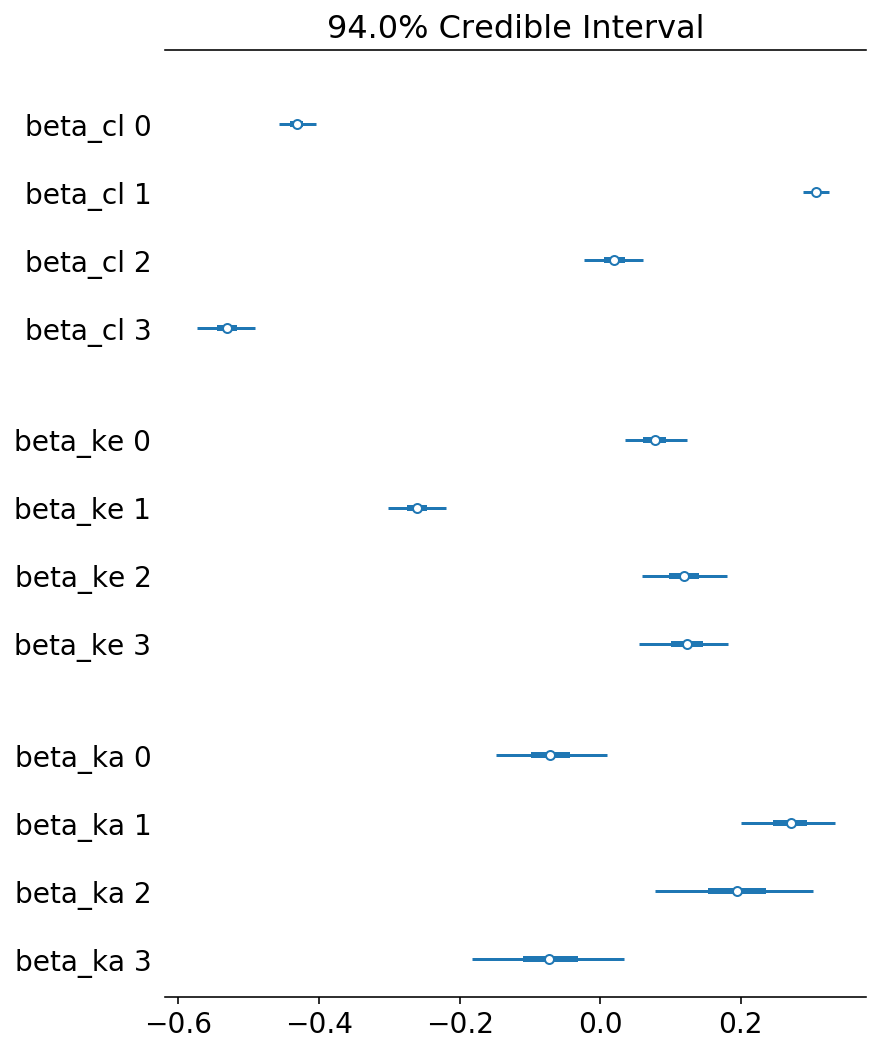

In [137]:
az.plot_forest(d, var_names=['beta_cl', 'beta_ke', 'beta_ka'], combined=True)

(<Figure size 432x547.2 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c5a4ce5f8>],
       dtype=object))

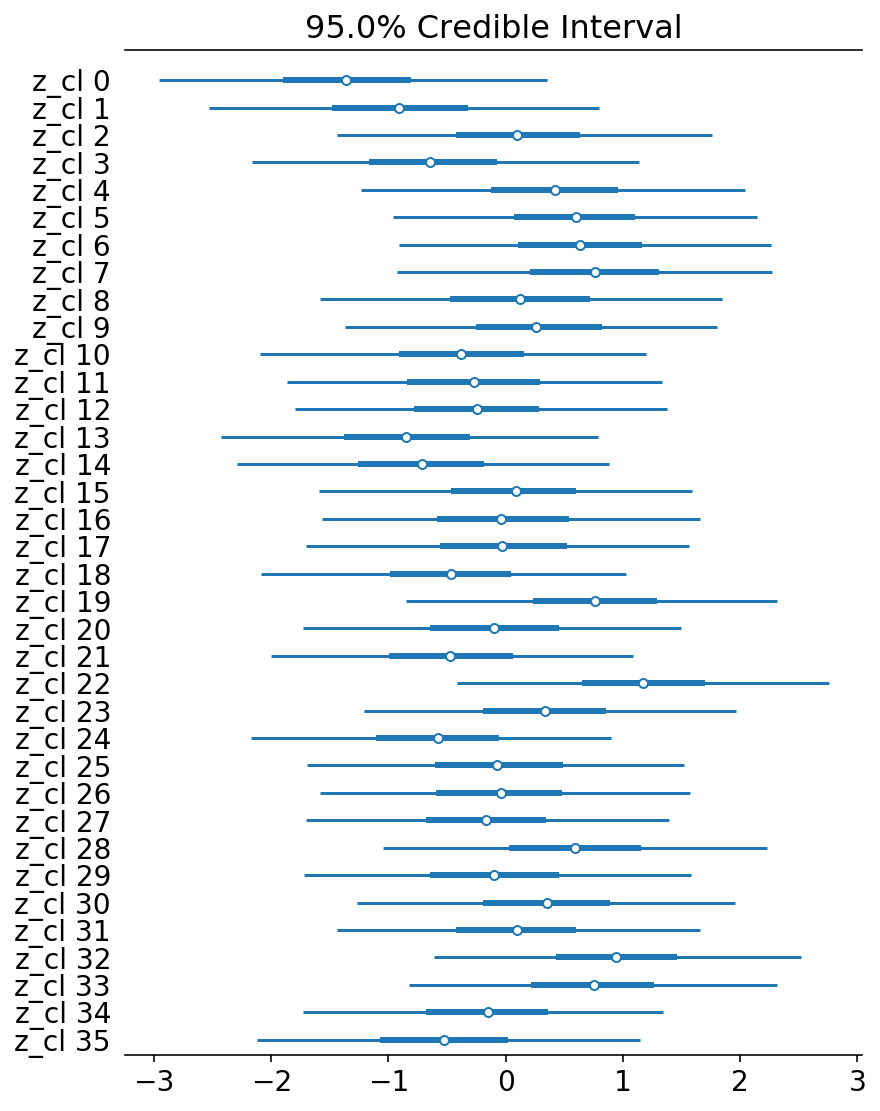

In [140]:
az.plot_forest(d, var_names=['z_cl'], 
               combined=True, credible_interval=.95)